In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **1. Dataset**

# 1.1 Profiling

In [ ]:
ls ../input/ifsp-d3apl-2023-face-recognition/train/train/

In [ ]:
import os

dataset_folder = '../input/ifsp-d3apl-2023-face-recognition/train/train/'

class_folders = sorted(os.listdir(dataset_folder))


print(class_folders)
print(f'Number of class: {len(class_folders)}')

In [ ]:
# show me the class proportions: number of samples per class
for class_folder in class_folders:
    full_class_folder = os.path.join(dataset_folder, class_folder)
    
    class_img_filenames = os.listdir(full_class_folder)
    print(f'Number of Images for Class "{class_folder}": {len(class_img_filenames)}')

In [ ]:
import os
import glob

# List of directories
#directories = ['dir1', 'dir2', 'dir3']

# Dictionary to store directory and file count
file_counts = {}

# Count files in each directory
for class_folder in class_folders:
    full_class_folder = os.path.join(dataset_folder, class_folder)
    file_counts[class_folder] = len(glob.glob(os.path.join(full_class_folder, '*')))

# Sort file counts by value in descending order
sorted_counts = sorted(file_counts.items(), key=lambda x: x[1], reverse=True)

print(sorted_counts)

# Print the sorted file counts
#for class_folder, count in sorted_counts:
#    print(f"{class_folder}: {count} files")


# 1.2 Duplicate the training data folder for oversampling

In [ ]:
import shutil
# Set the paths for the input and output directories
input_dir = dataset_folder
data_dir = '../working/oversampled'

# Duplicate the entire folder
shutil.copytree(input_dir, data_dir)


In [ ]:
import os
import glob

# List of directories
#directories = ['dir1', 'dir2', 'dir3']

# Dictionary to store directory and file count
file_counts = {}

class_folders = sorted(os.listdir(data_dir))

# Count files in each directory
for class_folder in class_folders:
    full_class_folder = os.path.join(data_dir, class_folder)
    file_counts[class_folder] = len(glob.glob(os.path.join(full_class_folder, '*')))

# Sort file counts by value in descending order
sorted_counts = sorted(file_counts.items(), key=lambda x: x[1], reverse=True)

print(sorted_counts)


In [ ]:
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image 
import PIL 

# Set the desired number of samples per class
desired_samples = 80

# Create an instance of the ImageDataGenerator
data_generator = ImageDataGenerator(
    #rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=40,  # Randomly rotate images within the range of 20 degrees
    #width_shift_range=0.1,  # Randomly shift the width of images by 10%
    #height_shift_range=0.1,  # Randomly shift the height of images by 10%
    shear_range=0.35,  # Apply random shear transformations
    zoom_range=0.35,  # Apply random zoom transformations
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill any newly created pixels after rotation or shifting
)

# Iterate through the folders representing each class
for class_folder in os.listdir(data_dir):
    class_folder_path = os.path.join(data_dir, class_folder)
    
    if os.path.isdir(class_folder_path):
        # Get the list of images in the current class folder
        images = os.listdir(class_folder_path)
        
        # Calculate the number of existing samples in the class
        existing_samples = len(images)
        
        if existing_samples < desired_samples:
            # Calculate the number of additional samples needed
            additional_samples = desired_samples - existing_samples
            
            # Randomly select images from the existing samples
            #selected_images = random.sample(images, additional_samples)
            
            # Create a data generator for the current class folder
            generator = data_generator.flow_from_directory(
                directory=data_dir,
                target_size=(100, 100),  # Adjust the target size as per your requirements
                batch_size=1,
                class_mode='categorical',
                classes=[class_folder],
                shuffle=True,
                save_to_dir=class_folder_path, 
                save_prefix='aug-',
                save_format='jpg'
            )
            
            # Generate additional samples using the data generator
            for i in range(additional_samples):
                batch = next(generator)
                imagem = batch[0]
                


In [ ]:
import os
import glob

# List of directories
#directories = ['dir1', 'dir2', 'dir3']

# Dictionary to store directory and file count
file_counts = {}

class_folders = sorted(os.listdir(data_dir))

# Count files in each directory
for class_folder in class_folders:
    full_class_folder = os.path.join(data_dir, class_folder)
    file_counts[class_folder] = len(glob.glob(os.path.join(full_class_folder, '*')))

# Sort file counts by value in descending order
sorted_counts = sorted(file_counts.items(), key=lambda x: x[1], reverse=True)

print(sorted_counts)

In [ ]:
#import shutil
#shutil.make_archive(data_dir, 'zip', '../working','oversampled')

# 1.3 Preprocessing the dataset

In [ ]:
max_n_samples_per_class = 50

In [ ]:
import random
import os

data_dir = '../working/oversampled'
dataset_folder = data_dir
class_folders = sorted(os.listdir(dataset_folder))

# OPTIONAL: just to get the same selected images
random.seed(22)

img_full_paths = []
img_classes = []

for class_folder in class_folders:
    img_class = class_folder  # english
    print(f'Class: {img_class}')  # italiano
    
    # translated class
    #img_class = translate[class_folder]  # english
    #print(f'Translation: {img_class}')  # italiano
    
    # get the full class folder pathname
    full_class_folder = os.path.join(dataset_folder, class_folder)
    print(full_class_folder)
    
    # get all image filenames (without their parent dir) for the current class/animal
    class_img_filenames = sorted(os.listdir(full_class_folder))
    print(len(class_img_filenames))
    
    #### undersampling from scratch
    ### one possible strategy to select `max_n_samples_per_class` of samples randomly
    # random.shuffle(class_img_filenames)
    # class_img_filenames = class_img_filenames[:max_n_samples_per_class]

    class_img_filenames = random.sample(class_img_filenames, max_n_samples_per_class)
    print(f'Number of images: {len(class_img_filenames)}')
    
    for img_filename in class_img_filenames:
        full_img_path = os.path.join(full_class_folder, img_filename)
        
        img_full_paths.append(full_img_path)
        img_classes.append(img_class)
    
    print()

In [ ]:
print(len(img_full_paths))

In [ ]:
print(len(img_classes))

In [ ]:
# creating a dataframe to store the image full pathnames and their corresponding classes
import pandas as pd

dataset_df = pd.DataFrame({
    'image_pathname': img_full_paths,
    'class': img_classes
})

dataset_df

In [ ]:
dataset_df['class'].value_counts()

# 1.4 Saving the preprocessed dataset

In [ ]:
dataset_df.to_csv('../working/faces_dataset_oversampled.csv', index=False)

# 1.5 Inspecting an image

In [ ]:
import cv2

In [ ]:
dataset_df.loc[0, 'image_pathname']

In [ ]:
# read an image
img = cv2.imread(dataset_df.loc[0, 'image_pathname'])
print(type(img))
img.shape

In [ ]:
# channel BLUE
img[:, :, 0]

In [ ]:
# channel GREEN
img[:, :, 1]

In [ ]:
# channel RED
img[:, :, 2]

In [ ]:
img.min(), img.max()

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(img)

In [ ]:
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img_RGB = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img_RGB)

In [ ]:
img = cv2.imread(dataset_df.loc[500, 'image_pathname'])  # BGR
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert BGR to RGB
plt.imshow(img)

In [ ]:
img.shape

# 1.6 Create the training dataset

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [ ]:
dataset_df

In [ ]:
dataset_df["class"].unique()

In [ ]:
class_names = sorted(dataset_df["class"].unique())
n_classes = len(class_names)

print(f'Number of classes: {n_classes}')
print(f'Classes: {class_names}')

In [ ]:
# number of samples per class
dataset_df['class'].value_counts()

In [ ]:
from sklearn.model_selection import train_test_split

# for a stratified sampling, we need to pass the labels
labels = dataset_df['class']

dataset_df_full_train, dataset_df_test = train_test_split(dataset_df, test_size=0.2, random_state=22, stratify=labels)

In [ ]:
dataset_df_full_train.shape

In [ ]:
dataset_df_full_train.head()

In [ ]:
dataset_df_test.shape

In [ ]:
# for a stratified sampling, we need to pass the labels
labels_full_train = dataset_df_full_train['class']
#labels = dataset_df['class']

dataset_df_train, dataset_df_val = train_test_split(dataset_df_full_train, train_size=0.8, random_state=22, stratify=labels_full_train)
#dataset_df_train, dataset_df_val = train_test_split(dataset_df, train_size=0.8, random_state=42, stratify=labels)

dataset_df_train['class'].value_counts()

In [ ]:
# checking class balancing in the validation set
dataset_df_val['class'].value_counts()

In [ ]:
dataset_df_test['class'].value_counts()

# 1.7 Preprocessing the images

In [ ]:
dataset_df.loc[0, 'image_pathname']

In [ ]:
import cv2
import matplotlib.pyplot as plt

# BGR
img = cv2.imread('../working/oversampled/Adam Sandler/73.jpg')
# BGR ==> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [ ]:
# aspect ratio = width / height
aspect_ratio = img.shape[0] / img.shape[1]
aspect_ratio

In [ ]:
import cv2
from sklearn.preprocessing import LabelEncoder
import numpy as np


#def preprocess_faces_dataset(dataset_df, label_encoder: LabelEncoder, new_img_dims=(100, 100), verbose=0):
def preprocess_faces_dataset(dataset_df, label_encoder: LabelEncoder, new_img_dims=(224, 224), verbose=0):
    # load the images as a feature matrix
    image_list = []  # list of numpy arrays
    
    for index, img_path in enumerate(dataset_df['image_pathname']):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # image resizing
        # for gray or color images, the linear interpolation sounds good
        img = cv2.resize(img, new_img_dims, interpolation=cv2.INTER_LINEAR)        
        image_list.append(img)
        
        if verbose and (index % verbose) == 0:
            print(f'{index + 1}/{dataset_df.shape[0]} - {img_path}')
    
    # numpy array 4D: n_imgs, height, width, n_channels
    X = np.array(image_list)
    
    # feature scaling
    # numpy arary 4D with values within [0, 1]
    X = X / 255.0
    
    # encoding the classes
    # numpy array 1D with integer labels
    y = label_encoder.transform(dataset_df['class'])
    
    return X, y

In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np
import math
import cv2


class MyGenerator(Sequence):
    def __init__(self, dataset_df, label_encoder, batch_size, new_dims=(100, 100)):
        self.dataset_df = dataset_df
        self.label_encoder = label_encoder
        self.batch_size = batch_size
        self.new_dims = new_dims
    
    
    def __len__(self):
        n_samples = self.dataset_df.shape[0]
        
        return math.ceil(n_samples / float(self.batch_size))
    
    
    def __getitem__(self, idx):
        batch_begin = idx * self.batch_size
        batch_end = (idx + 1) * self.batch_size
        
        batch_df = self.dataset_df[batch_begin:batch_end]
        
        X_batch, y_batch = preprocess_faces_dataset(batch_df, self.label_encoder, self.new_dims, verbose=0)
        #X_batch, y_batch = preprocess_faces_dataset(batch_df, self.label_encoder, self.new_dims)
                
        return X_batch, y_batch

In [ ]:
# training a Label Encoder from the train set
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(dataset_df_train['class'])

label_encoder.classes_

In [ ]:
#batch_size = 83

#training_batch_generator = MyGenerator(dataset_df_train, label_encoder, batch_size, new_dims=(100, 100))
#validation_batch_generator = MyGenerator(dataset_df_val, label_encoder, batch_size, new_dims=(100, 100))
#test_batch_generator = MyGenerator(dataset_df_test, label_encoder, batch_size, new_dims=(100, 100))

In [ ]:
#test_batch_generator = MyGenerator(dataset_df_test, label_encoder, batch_size, new_dims=(100, 100))

In [ ]:
# transform/map the string class to the trained numeric class
#label_encoder.transform(['Alec Baldwin', 'Claudia Schiffer', 'Zac Efron'])

In [ ]:
# preprocessing the train set
#X_train, y_train = preprocess_faces_dataset(dataset_df_train, label_encoder)
#X_train, y_train = preprocess_faces_dataset(dataset_df_train, label_encoder, new_img_dims=(100, 100))
X_train, y_train = preprocess_faces_dataset(dataset_df_train, label_encoder, new_img_dims=(224, 224))

In [ ]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train (classes): {np.unique(y_train)}')
print(f'y_train.shape: {y_train.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_train: {X_train.min()}')
print(f'Max. value of X_train: {X_train.max()}\n')

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])

In [ ]:

# preprocessing the validation set
#X_val, y_val = preprocess_faces_dataset(dataset_df_val, label_encoder)
#X_val, y_val = preprocess_faces_dataset(dataset_df_val, label_encoder, new_img_dims=(100, 100))
X_val, y_val = preprocess_faces_dataset(dataset_df_val, label_encoder, new_img_dims=(224, 224))

In [ ]:

print(f'X_val.shape: {X_val.shape}')
print(f'y_val (classes): {np.unique(y_val)}')
print(f'y_val.shape: {y_val.shape}')

# rescaled 24-bit color image
print(f'Min. value of X_val: {X_val.min()}')
print(f'Max. value of X_val: {X_val.max()}\n')


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_val[0])

In [ ]:
# preprocessing the test set
#X_test, y_test = preprocess_faces_dataset(dataset_df_test, label_encoder, new_img_dims=(100, 100))
X_test, y_test = preprocess_faces_dataset(dataset_df_test, label_encoder, new_img_dims=(224, 224))

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_test[0])

# 1.8 Saving the preprocessed data

In [ ]:
import os

out_dir = '../working/preprocessed'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
dataset_df_full_train.to_csv(os.path.join(out_dir, 'full_train.csv'), index=False)

dataset_df_train.to_csv(os.path.join(out_dir, 'train.csv'), index=False)
np.save(os.path.join(out_dir, 'train_data_64x64x3.npy'), X_train)
np.save(os.path.join(out_dir, 'train_labels.npy'), y_train)

dataset_df_val.to_csv(os.path.join(out_dir, 'validation.csv'), index=False)
np.save(os.path.join(out_dir, 'validation_data_64x64x3.npy'), X_val)
np.save(os.path.join(out_dir, 'validation_labels.npy'), y_val)

dataset_df_test.to_csv(os.path.join(out_dir, 'test.csv'), index=False)
np.save(os.path.join(out_dir, 'test_data_64x64x3.npy'), X_test)
np.save(os.path.join(out_dir, 'test_labels.npy'), y_test)


# 2 Training the model

# 2.1 Stablish base model for transfer learning VGG16

In [ ]:
'''
# https://keras.io/api/applications/vgg/
# https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4

from tensorflow.keras.applications import VGG16

base_model = VGG16(include_top=None,   # we will ignore the top layers that consists of the MLP classifier of VGG16
                   weights="imagenet", # we will use the weights learned for the ImageNet dataset
                   input_shape=(100, 100, 3))  # let's consider a smaller resolution than the original paper due to lack of memory


# freeze the base model weights ==> these weights won't be updated during training
# i.e., the weights of all layers from the base model are not updated
base_model.trainable = False
'''

In [ ]:
#!pip install keras-vggface
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install Keras-Applications

    
filename = "/opt/conda/lib/python3.10/site-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf

from keras_vggface.vggface import VGGFace
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout



In [ ]:

import tensorflow as tf

from keras_vggface.vggface import VGGFace
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout



#from keras_vggface.vggface import VGGFace

# Based on VGG16 architecture -> old paper(2015)
#vggface = VGGFace(model='vgg16') # or VGGFace() as default

# Based on RESNET50 architecture -> new paper(2017)
vggface = VGGFace(model='resnet50')

# Based on SENET50 architecture -> new paper(2017)
#vggface = VGGFace(model='senet50')


#from keras.engine import  Model
#from keras.layers import Input
#from keras_vggface.vggface import VGGFace

# Convolution Features
#vgg_features = VGGFace(include_top=False, input_shape=(100, 100, 3), pooling='avg') # pooling: None, avg or max
vgg_features = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max

# After this point you can use your model to predict.
# ...

#from keras.engine import  Model
#from keras.layers import Input
#from keras_vggface.vggface import VGGFace

# Layer Features
#layer_name = 'layer_name' # edit this line
#vgg_model = VGGFace() # pooling: None, avg or max
#out = vgg_model.get_layer(layer_name).output
#vgg_model_new = Model(vgg_model.input, out)

# After this point you can use your model to predict.
# ...

#from keras.engine import  Model
#from keras.layers import Flatten, Dense, Input
#from keras_vggface.vggface import VGGFace

#custom parameters
nb_class = 83
hidden_dim = 128

#vgg_model = VGGFace(include_top=False, input_shape=(100, 100, 3))
vgg_model = VGGFace(include_top=False, input_shape=(224, 224, 3))
vgg_model.trainable = False
last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
x = Dropout(0.3)(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
vggface_model = Model(vgg_model.input, out)

# Train your model as usual.
# ...

'''
def define_vggface_model(input_shape, num_classes):
    # Load the VGGFace model
    vggface_model = VGGFace(model='vgg16', weights='vggface', include_top=False, input_shape=input_shape)

    # Freeze the layers of the VGGFace model
    for layer in vggface_model.layers:
       layer.trainable = False

    # Flatten the output of the VGGFace model
    x = Flatten()(vggface_model.output)
    #x = Flatten()(vggface_model.get_layer('avg_pool').output)

    # Add a fully connected layer with dropout
    #x = Dense(1024, activation='relu')(x)
    #x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)

    # Add the output layer for the desired number of classes
    output = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=vggface_model.input, outputs=output)

    return model

# Define the input shape of your images and the number of classes
input_shape = (100, 100, 3)
num_classes = 83

# Create the VGGFace transfer learning model
vggface_model = define_vggface_model(input_shape, num_classes)

'''

# Print a summary of the model architecture
vggface_model.summary()

In [ ]:
#base_model = VGGFace(model='vgg16', include_top=None,   # we will ignore the top layers that consists of the MLP classifier of VGG16
                   #weights='vggface', # we will use the weights learned for the ImageNet dataset
                   #input_shape=(100, 100, 3))  # let's consider a smaller resolution than the original paper due to lack of memory

#base_model.trainable = False
#vgg_model.trainable = False

In [ ]:
#base_model.summary()

In [ ]:
#base_model.summary()

# 2.2 Define the connected model

In [ ]:
'''
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation

model = Sequential([
    # our base model - feature extraction
    base_model,

    # data augmentation layers
#        RandomFlip("horizontal"),
#        RandomRotation(factor=0.1),
#        RandomTranslation(height_factor=0.1, width_factor=0.1),
        
        # CNN
#        Conv2D(filters=32, kernel_size=(1,1), activation='relu'),
#        MaxPool2D(pool_size=(1,1)),
#        Conv2D(filters=32, kernel_size=(1,1), activation='relu'),
 #       MaxPool2D(pool_size=(1,1)),
  
    
    Flatten(),
    
    # FC classifier
  Dense(512, activation='relu'),
    # Dense(256, activation='relu'),
 #  Dense(128, activation='relu'),
  #  Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(83, activation='softmax')
])
'''

In [ ]:
vggface_model.summary()

In [ ]:
#model.summary()

# 2.3 Compile and run the model

In [ ]:
from tensorflow.keras.optimizers import Adam
#opt = Adam(learning_rate=0.001)
opt = Adam(learning_rate=0.0005)
#model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
vggface_model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
import tensorflow
early_stopping_cb = tensorflow.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [ ]:
history = vggface_model.fit(X_train, y_train, epochs=20, batch_size=83, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
#history = model.fit(training_batch_generator, epochs=20, validation_data=validation_batch_generator, callbacks=[early_stopping_cb],  use_multiprocessing=True, workers=16, max_queue_size=32)


#history = vggface_model.fit_generator(training_batch_generator, epochs=20, validation_data=validation_batch_generator, callbacks=[early_stopping_cb],  use_multiprocessing=True, workers=16, max_queue_size=32)
                    # Used for generator or keras.utils.Sequence input only
                   

In [ ]:
from tensorflow.keras.utils import plot_model
# vertical
plot_model(vggface_model, show_shapes=True, show_layer_activations=True)

In [76]:
# creates a HDF5 file
vggface_model.save('../working/'+
    'transfer_learning_trained' +
    '_face_cnn_model.h5')

# 2.4 Visualizing the training history

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

Text(0, 0.5, 'Score')

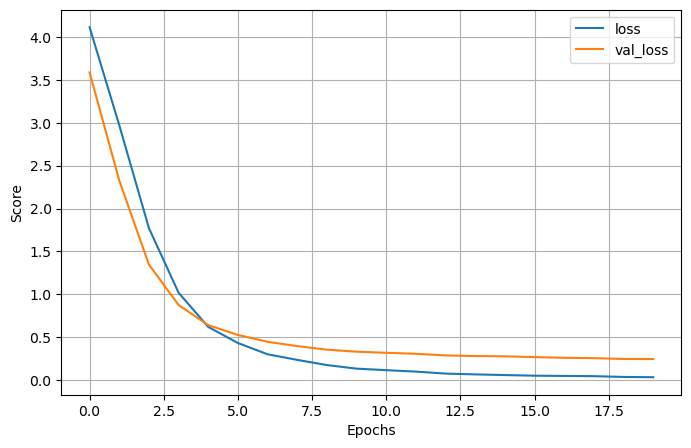

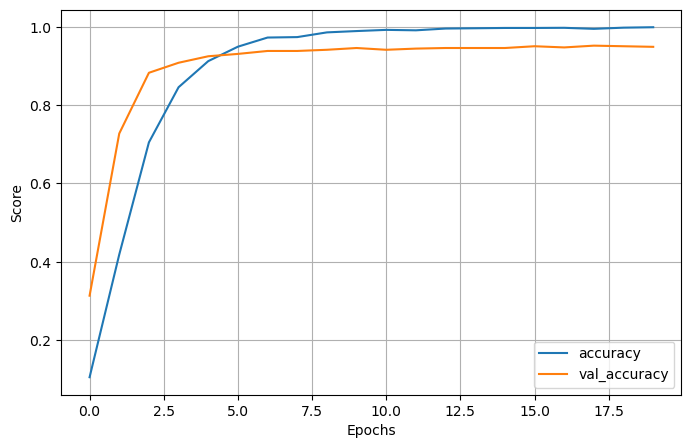

In [78]:
history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')

history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Score')

In [ ]:
# checking class balancing in the training set
#test_folder = '../input/ifsp-d3apl-2023-face-recognition/test/test/'

#dataset_df_test['class'].value_counts()

# Model evaluation

In [79]:
vggface_model.evaluate(X_test, y_test)
#model.evaluate(test_batch_generator)

26/26 [==============================] - 6s 145ms/step - loss: 0.2677 - accuracy: 0.9506


[0.26765257120132446, 0.9506024122238159]

In [80]:
y_test_proba = vggface_model.predict(X_test)
#y_test_proba = model.predict(test_batch_generator)
y_test_proba

26/26 [==============================] - 2s 66ms/step


array([[1.37973132e-07, 1.61049769e-07, 1.76186305e-07, ...,
        5.80304402e-07, 5.24264117e-08, 2.24505948e-05],
       [3.09443681e-06, 9.30967758e-07, 1.08022832e-07, ...,
        8.04799981e-07, 1.26467825e-07, 3.49002244e-06],
       [1.17277295e-06, 8.71555343e-08, 2.13005944e-04, ...,
        2.18347211e-07, 2.00181671e-06, 1.15996409e-05],
       ...,
       [3.32380701e-08, 2.01427795e-07, 7.91645149e-08, ...,
        4.21567989e-07, 1.16023879e-09, 2.03947881e-08],
       [4.46438607e-05, 1.67361725e-06, 4.16615949e-04, ...,
        2.22440158e-05, 4.80818650e-04, 1.14393163e-06],
       [9.51604073e-11, 3.79163610e-11, 8.66964227e-04, ...,
        2.50253015e-06, 1.13088106e-07, 1.92930429e-07]], dtype=float32)

In [81]:
y_test_pred = np.argmax(y_test_proba, axis=1)
y_test_pred

array([42, 67, 47, 62,  5, 73, 42, 12, 34, 41, 17, 52, 67, 59, 82, 42, 17,
       81, 63, 23, 40, 33, 11, 18, 70, 61,  2, 77, 29, 33, 11, 76,  6,  3,
       61,  3, 53, 63, 25,  1, 53, 10, 18, 13, 12, 79, 33,  1, 69, 10, 20,
       44, 10, 28, 47, 51, 49, 33,  6, 27, 31, 67, 27, 73, 36, 18, 37, 49,
       72,  9,  7, 45, 48, 20, 57, 42, 68, 45, 43, 48, 49, 62,  3,  5, 15,
       27,  7, 61, 40, 63, 59, 64, 16, 67, 30,  7, 78, 54, 52, 50, 66, 69,
        8, 32, 19, 10, 12, 69, 49, 20, 71, 75, 13, 12, 40, 60, 15, 81, 63,
       44, 28, 48, 15, 66, 74, 67, 43, 37,  0, 20, 17, 80, 45, 76, 64, 29,
       12,  6, 47, 52, 26, 50, 19, 39, 26, 62, 34, 14, 45, 32, 14, 40, 64,
       56, 15, 79, 54, 14, 11, 62, 16, 72, 73, 31, 78, 69, 19, 47, 28, 81,
       46, 42, 49, 44, 14,  4,  3, 34, 60, 65, 25, 63, 52, 78, 16, 70, 36,
       42, 55, 64,  8, 15, 17, 14,  6, 35, 62, 29,  5, 32,  7, 59,  7, 78,
       30,  6, 68, 80, 81, 29, 22, 24, 41, 51, 44,  5, 17, 15, 22,  4, 40,
        8, 59, 56, 32, 23

In [82]:
from sklearn.metrics import classification_report

y_test = label_encoder.transform(dataset_df_test['class'])
class_names = label_encoder.classes_

print(classification_report(y_test, y_test_pred, target_names=[name for name in class_names]))

                      precision    recall  f1-score   support

        Adam Sandler       1.00      0.90      0.95        10
        Alec Baldwin       0.90      0.90      0.90        10
      Angelina Jolie       1.00      1.00      1.00        10
     Anna Kournikova       0.71      1.00      0.83        10
      Ashton Kutcher       1.00      0.90      0.95        10
       Avril Lavigne       0.91      1.00      0.95        10
        Barack Obama       1.00      1.00      1.00        10
         Ben Affleck       1.00      1.00      1.00        10
     Beyonce Knowles       1.00      1.00      1.00        10
           Brad Pitt       0.88      0.70      0.78        10
        Cameron Diaz       1.00      1.00      1.00        10
      Cate Blanchett       0.91      1.00      0.95        10
     Charlize Theron       0.82      0.90      0.86        10
     Christina Ricci       1.00      0.90      0.95        10
    Claudia Schiffer       1.00      1.00      1.00        10
       

# Generating prediciton file for submission

In [83]:
#import os

# checking class balancing in the training set
test_folder = '../input/ifsp-d3apl-2023-face-recognition/test/test/'

img_test_list = sorted(os.listdir(test_folder))

img_test_full_paths = []
#img_pred_classes = []

for img_test in img_test_list:
    full_img_test_path = os.path.join(test_folder, img_test)
    img_test_full_paths.append(full_img_test_path)

# creating a dataframe to store the image full pathnames and their corresponding classes
#import pandas as pd

dataset_sub_test = pd.DataFrame({
    'image_pathname': img_test_full_paths
   })

dataset_sub_test
    
    # print()
#print(img_test_list)

,image_pathname
0,../input/ifsp-d3apl-2023-face-recognition/test...
1,../input/ifsp-d3apl-2023-face-recognition/test...
2,../input/ifsp-d3apl-2023-face-recognition/test...
3,../input/ifsp-d3apl-2023-face-recognition/test...
4,../input/ifsp-d3apl-2023-face-recognition/test...
...,...
1655,../input/ifsp-d3apl-2023-face-recognition/test...
1656,../input/ifsp-d3apl-2023-face-recognition/test...
1657,../input/ifsp-d3apl-2023-face-recognition/test...
1658,../input/ifsp-d3apl-2023-face-recognition/test...


In [84]:
dataset_sub_test['image_pathname'].value_counts()

../input/ifsp-d3apl-2023-face-recognition/test/test/0001.jpg    1
../input/ifsp-d3apl-2023-face-recognition/test/test/1104.jpg    1
../input/ifsp-d3apl-2023-face-recognition/test/test/1114.jpg    1
../input/ifsp-d3apl-2023-face-recognition/test/test/1113.jpg    1
../input/ifsp-d3apl-2023-face-recognition/test/test/1112.jpg    1
                                                               ..
../input/ifsp-d3apl-2023-face-recognition/test/test/0551.jpg    1
../input/ifsp-d3apl-2023-face-recognition/test/test/0550.jpg    1
../input/ifsp-d3apl-2023-face-recognition/test/test/0549.jpg    1
../input/ifsp-d3apl-2023-face-recognition/test/test/0548.jpg    1
../input/ifsp-d3apl-2023-face-recognition/test/test/1660.jpg    1
Name: image_pathname, Length: 1660, dtype: int64

In [85]:
import cv2
from sklearn.preprocessing import LabelEncoder
import numpy as np


def preprocess_faces_dataset(dataset_df, label_encoder: LabelEncoder, new_img_dims=(224, 224), verbose=0):
    # load the images as a feature matrix
    image_list = []  # list of numpy arrays
    
    for index, img_path in enumerate(dataset_df['image_pathname']):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # image resizing
        # for gray or color images, the linear interpolation sounds good
        img = cv2.resize(img, new_img_dims, interpolation=cv2.INTER_LINEAR)        
        image_list.append(img)
        
        if verbose and (index % verbose) == 0:
            print(f'{index + 1}/{dataset_df.shape[0]} - {img_path}')
    
    # numpy array 4D: n_imgs, height, width, n_channels
    X = np.array(image_list)
    
    # feature scaling
    # numpy arary 4D with values within [0, 1]
    X = X / 255.0
    
    # encoding the classes
    # numpy array 1D with integer labels
    #y = label_encoder.transform(dataset_df['class'])
    
    return X

x_test=preprocess_faces_dataset(dataset_sub_test, label_encoder, new_img_dims=(224, 224))
x_test


array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [86]:
import os

out_dir = '../working/preprocessed'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
dataset_sub_test.to_csv(os.path.join(out_dir, 'sub_test.csv'), index=False)
np.save(os.path.join(out_dir, 'test_data_224x224x3.npy'), x_test)


In [87]:
y_test_proba = vggface_model.predict(x_test)
y_test_proba

52/52 [==============================] - 5s 105ms/step


array([[2.0593021e-07, 9.0546799e-08, 2.0430905e-06, ..., 5.5493354e-07,
        1.4001983e-10, 7.0754942e-07],
       [3.0951167e-08, 1.7663991e-06, 2.2907548e-06, ..., 7.9415528e-05,
        8.9203261e-10, 2.5222838e-07],
       [8.6962324e-08, 2.0471357e-06, 1.2032401e-06, ..., 7.0835326e-06,
        1.0796987e-07, 4.9296812e-08],
       ...,
       [2.6286520e-10, 5.1571993e-12, 3.4656512e-06, ..., 2.0731246e-08,
        5.1051097e-10, 3.7897974e-09],
       [1.8992984e-06, 2.8640408e-05, 5.4342585e-05, ..., 1.2632847e-06,
        6.1206109e-08, 1.5135144e-05],
       [2.8402565e-05, 7.0134543e-02, 2.7666543e-05, ..., 1.3041703e-04,
        1.2605022e-06, 9.8209872e-05]], dtype=float32)

In [88]:
y_test_pred = np.argmax(y_test_proba, axis=1)
y_test_pred


array([28, 19, 76, ..., 53, 37, 29])

In [89]:
len(y_test_pred)

1660

In [90]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
class_names = label_encoder.classes_

#y_test_pred = label_encoder.transform(dataset_df_test['class'])

le_fitted = le.fit_transform(class_names)

inverted = le.inverse_transform(y_test_pred)

print(inverted)
len(inverted)

['Faith Hill' 'Daniel Craig' 'Steve Carell' ... 'Mariah Carey'
 'Jennifer Aniston' 'George Clooney']


1660

In [91]:
image_id=list(range(1661))
image_id.pop(0)
len(image_id)



1660

In [92]:
dataset_submission = pd.DataFrame({
    'image-id': image_id,
    'prediction': inverted
   })

dataset_submission

,image-id,prediction
0,1,Faith Hill
1,2,Daniel Craig
2,3,Steve Carell
3,4,Alec Baldwin
4,5,Michael Bloomberg
...,...,...
1655,1656,Stephen Colbert
1656,1657,Kate Winslet
1657,1658,Mariah Carey
1658,1659,Jennifer Aniston


In [93]:
dataset_submission.to_csv('../working/prediction_400.csv', index=False)